In [1]:
import pandas  as pd
import xgboost as xgb
import seaborn as sns
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import os
from utils import run_kfold_eval, calculate_metric
import optuna
import time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
DATA_FOLDER = "../data"
TRAIN_FEATURES = DATA_FOLDER + '/train_features_w_one_hot_enc.xlsx'
TRAIN_LABELS = DATA_FOLDER + "/train_labels.xlsx"
TEST_FEATURES = DATA_FOLDER + "/test_features_w_one_hot_enc.xlsx"
TEST_LABELS = DATA_FOLDER + "/test_labels.xlsx"
OUTPUT_PATH = '../output/xgboost'

In [3]:
train_features = pd.read_excel(TRAIN_FEATURES)
train_labels = pd.read_excel(TRAIN_LABELS)
test_features = pd.read_excel(TEST_FEATURES)
test_labels = pd.read_excel(TEST_LABELS)

In [4]:
test_features.head()

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,exit_type_subcategory_ Reason: Interest payment,exit_type_subcategory_ Reason: Loan payment,exit_type_subcategory_ Reason: Principal payment,exit_type_subcategory_ Reason: Unknown,exit_type_subcategory_0,exit_type_subcategory_Reason: Buyback option,exit_type_subcategory_Reason:From CBil (monthly update),exit_type_subcategory_Reason:From CBil (new/revised),defaulted_in_last_5_years_True,defaulted_in_last_6_months_True
0,3.125,-122.39680,-0.001341,1.116103,396.408936,399.031738,455.0625,383.612488,341.675812,0.1734,...,0,0,0,0,0,0,0,0,0,0
1,15.000,156.01912,0.000790,6.372588,107.083778,76.414360,118.2482,113.403519,147.756165,0.0253,...,0,0,0,0,0,0,0,0,0,0
2,0.000,-451.10824,-0.002033,43.914617,637.607544,689.770996,683.3611,589.969666,529.166992,0.0406,...,0,0,1,0,0,0,0,0,0,0
3,5.875,-751.22120,-0.000435,74.783398,153.653778,129.425842,158.3252,172.708054,187.147980,1.4908,...,0,0,0,0,0,0,0,0,0,0
4,10.000,55.69036,0.000712,-28.522133,152.290619,148.385330,222.1811,142.140915,159.624313,0.0763,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(1293, 419)
(1293, 1)
(432, 419)
(432, 1)


In [6]:
feature_list = train_features.columns
# category_feature_key = ['currency', 'seniorioty_adj', 'domicile_country',	'exchange_country',	'Industry_sector',	'Industry_group',	'Industry_subgroup', 'event_type',
#                  'event_type_subcategory_sum', 'defaulted_in_last_6_months']
# category_features = [i for i in feature_list if any(sub in i for sub in category_feature_key)]
category_features = train_features.select_dtypes(include=['int']).columns
non_category_features = [i for i in feature_list if i not in category_features]

print(len(category_features))
print(len(non_category_features))

265
154


In [7]:
non_category_features

['coupon rate',
 'SP500 MD',
 'Average daily 1-year SP500 return',
 'Ratio to MA',
 'US Corporate Bond Yield Spread',
 'US Corporate Bond Yield Spread(3-5 year)',
 'US Corporate Bond Yield Spread(5-7 year)',
 'US Corporate Bond Yield Spread(7-10 year)',
 'US Corporate Bond Yield Spread(10+ year)',
 'US Generic Govt 3 Month Yield',
 'US Generic Govt 6 Month Yield',
 'US Generic Govt 12 Month Yield',
 'US Generic Govt 2 Year Yield',
 'US Generic Govt 3 Year Yield',
 'US Generic Govt 5 Year Yield',
 'US Generic Govt 7 Year Yield',
 'US Generic Govt 10 Year Yield',
 'marketcap',
 'sector_domicile_dtd',
 'sector_exchange_dtd',
 'sector_dtd',
 'PD_1_domicile_sector',
 'PD_3_domicile_sector',
 'PD_12_domicile_sector',
 'PD_1_domicile_subsec',
 'PD_3_domicile_subsec',
 'PD_12_domicile_subsec',
 'PD_1_exch_sector',
 'PD_3_exch_sector',
 'PD_12_exch_sector',
 'PD_1_exch_subsector',
 'PD_3_exch_subsector',
 'PD_12_exch_subsector',
 'PD_1_global_sector',
 'PD_3_global_sector',
 'PD_12_global_secto

In [8]:
# Normalize the data
# Prepare the ColumnTransformer

scaler = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), non_category_features)   # StandardScaler()
    ],
    remainder='passthrough'  # Leave categorical features untouched
)

In [32]:
def objective(trial):

    param = {
        # "verbosity": 0,
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, log=True),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        # "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        # "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }
    
    if param["booster"] in "gbtree":
        # sampling according to each tree.
        param["colsample_bytree"] = trial.suggest_float("colsample_bytree", 0.2, 1.0)
        # sampling ratio for training data.
        param["subsample"] = trial.suggest_float("subsample", 0.2, 1.0)
        # use exact for small dataset.
        param["tree_method"] = trial.suggest_categorical("tree_method", ["exact", "auto"])

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 28, step=2)
        # minimum child weight, larger the term more conservative the tree.
        # param["min_child_weight"] = trial.suggest_int("min_child_weight", 1, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        # param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        # param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
        
    model = xgb.XGBRegressor(n_jobs=-1, **param)
    
    pipeline = Pipeline([
        ('preprocessor', scaler),
        ('xgboost', model)
    ])
    
    score = cross_val_score(pipeline, train_features, train_labels.to_numpy(), cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
    return score

In [33]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-12-06 10:27:50,434] A new study created in memory with name: no-name-2803a688-a756-46b2-ac6c-8748614312f0
Best trial: 0. Best value: -0.329108:   2%|▏         | 1/50 [05:00<4:05:46, 300.96s/it]

[I 2024-12-06 10:32:51,445] Trial 0 finished with value: -0.3291082831507967 and parameters: {'n_estimators': 253, 'booster': 'dart', 'max_depth': 10, 'eta': 4.8065474472033255e-06, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.211214181878596e-05, 'skip_drop': 7.64509496510699e-05}. Best is trial 0 with value: -0.3291082831507967.


Best trial: 0. Best value: -0.329108:   4%|▍         | 2/50 [06:32<2:22:10, 177.73s/it]

[I 2024-12-06 10:34:22,915] Trial 1 finished with value: -0.32929971904892047 and parameters: {'n_estimators': 134, 'booster': 'dart', 'max_depth': 10, 'eta': 6.343066833272886e-08, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0002871941547973696, 'skip_drop': 0.008331160822907531}. Best is trial 0 with value: -0.3291082831507967.


Best trial: 2. Best value: -0.288692:   6%|▌         | 3/50 [06:33<1:16:06, 97.15s/it] 

[I 2024-12-06 10:34:24,185] Trial 2 finished with value: -0.28869206081669874 and parameters: {'n_estimators': 317, 'booster': 'gblinear'}. Best is trial 2 with value: -0.28869206081669874.


Best trial: 2. Best value: -0.288692:   8%|▊         | 4/50 [06:35<45:37, 59.52s/it]  

[I 2024-12-06 10:34:26,017] Trial 3 finished with value: -0.31011821463310435 and parameters: {'n_estimators': 445, 'booster': 'gblinear'}. Best is trial 2 with value: -0.28869206081669874.


Best trial: 4. Best value: -0.286824:  10%|█         | 5/50 [06:37<29:04, 38.76s/it]

[I 2024-12-06 10:34:27,971] Trial 4 finished with value: -0.2868244475024252 and parameters: {'n_estimators': 245, 'booster': 'gblinear'}. Best is trial 4 with value: -0.2868244475024252.


Best trial: 4. Best value: -0.286824:  12%|█▏        | 6/50 [06:40<19:34, 26.69s/it]

[I 2024-12-06 10:34:31,234] Trial 5 finished with value: -0.32903019804697625 and parameters: {'n_estimators': 261, 'booster': 'gbtree', 'colsample_bytree': 0.8127694347734428, 'subsample': 0.5385936131438352, 'tree_method': 'exact', 'max_depth': 2, 'eta': 1.5290430800441443e-05}. Best is trial 4 with value: -0.2868244475024252.


Best trial: 4. Best value: -0.286824:  14%|█▍        | 7/50 [35:34<6:59:11, 584.92s/it]

[I 2024-12-06 11:03:25,430] Trial 6 finished with value: -0.32548346237058096 and parameters: {'n_estimators': 640, 'booster': 'dart', 'max_depth': 26, 'eta': 3.7331802918417095e-05, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.0004750381830743017, 'skip_drop': 0.0005964088447133102}. Best is trial 4 with value: -0.2868244475024252.


Best trial: 7. Best value: -0.260981:  16%|█▌        | 8/50 [35:50<4:42:39, 403.80s/it]

[I 2024-12-06 11:03:41,433] Trial 7 finished with value: -0.26098123434315124 and parameters: {'n_estimators': 326, 'booster': 'gbtree', 'colsample_bytree': 0.42892151555207464, 'subsample': 0.5662627100841591, 'tree_method': 'exact', 'max_depth': 16, 'eta': 0.4010310312545449}. Best is trial 7 with value: -0.26098123434315124.


Best trial: 7. Best value: -0.260981:  18%|█▊        | 9/50 [37:22<3:29:13, 306.18s/it]

[I 2024-12-06 11:05:12,964] Trial 8 finished with value: -0.32929800725837854 and parameters: {'n_estimators': 119, 'booster': 'dart', 'max_depth': 24, 'eta': 1.692791856635845e-07, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 4.432399295107948e-08, 'skip_drop': 0.15621565383081445}. Best is trial 7 with value: -0.26098123434315124.


Best trial: 7. Best value: -0.260981:  20%|██        | 10/50 [38:56<2:40:26, 240.67s/it]

[I 2024-12-06 11:06:46,935] Trial 9 finished with value: -0.32930026669784723 and parameters: {'n_estimators': 538, 'booster': 'gbtree', 'colsample_bytree': 0.456690395549923, 'subsample': 0.6527505782735947, 'tree_method': 'auto', 'max_depth': 20, 'eta': 3.363490386637671e-08}. Best is trial 7 with value: -0.26098123434315124.


Best trial: 7. Best value: -0.260981:  22%|██▏       | 11/50 [38:59<1:49:15, 168.09s/it]

[I 2024-12-06 11:06:50,451] Trial 10 finished with value: -3.9833834772349483 and parameters: {'n_estimators': 169, 'booster': 'gbtree', 'colsample_bytree': 0.2991617352757825, 'subsample': 0.2437967384912017, 'tree_method': 'exact', 'max_depth': 16, 'eta': 0.9597559654727174}. Best is trial 7 with value: -0.26098123434315124.


Best trial: 7. Best value: -0.260981:  24%|██▍       | 12/50 [39:04<1:14:59, 118.40s/it]

[I 2024-12-06 11:06:55,197] Trial 11 finished with value: -0.3677626719118858 and parameters: {'n_estimators': 873, 'booster': 'gblinear'}. Best is trial 7 with value: -0.26098123434315124.


Best trial: 12. Best value: -0.242612:  26%|██▌       | 13/50 [39:22<54:10, 87.84s/it]   

[I 2024-12-06 11:07:12,719] Trial 12 finished with value: -0.2426123165392006 and parameters: {'n_estimators': 361, 'booster': 'gbtree', 'colsample_bytree': 0.6704867326162939, 'subsample': 0.9511343631152693, 'tree_method': 'exact', 'max_depth': 10, 'eta': 0.2091050505597566}. Best is trial 12 with value: -0.2426123165392006.


Best trial: 12. Best value: -0.242612:  28%|██▊       | 14/50 [39:37<39:37, 66.04s/it]

[I 2024-12-06 11:07:28,396] Trial 13 finished with value: -0.24316802573885474 and parameters: {'n_estimators': 383, 'booster': 'gbtree', 'colsample_bytree': 0.7012473141411797, 'subsample': 0.9714838814449994, 'tree_method': 'exact', 'max_depth': 10, 'eta': 0.2845960720731056}. Best is trial 12 with value: -0.2426123165392006.


Best trial: 14. Best value: -0.230724:  30%|███       | 15/50 [39:58<30:33, 52.38s/it]

[I 2024-12-06 11:07:49,104] Trial 14 finished with value: -0.23072449543193524 and parameters: {'n_estimators': 441, 'booster': 'gbtree', 'colsample_bytree': 0.724960775288803, 'subsample': 0.9665268916917371, 'tree_method': 'exact', 'max_depth': 8, 'eta': 0.016293382824298038}. Best is trial 14 with value: -0.23072449543193524.


Best trial: 14. Best value: -0.230724:  32%|███▏      | 16/50 [40:19<24:23, 43.04s/it]

[I 2024-12-06 11:08:10,478] Trial 15 finished with value: -0.24449238763400408 and parameters: {'n_estimators': 739, 'booster': 'gbtree', 'colsample_bytree': 0.9082008574060376, 'subsample': 0.9915921153175385, 'tree_method': 'exact', 'max_depth': 4, 'eta': 0.004813328152115737}. Best is trial 14 with value: -0.23072449543193524.


Best trial: 14. Best value: -0.230724:  34%|███▍      | 17/50 [40:37<19:24, 35.30s/it]

[I 2024-12-06 11:08:27,764] Trial 16 finished with value: -0.24014390563508986 and parameters: {'n_estimators': 502, 'booster': 'gbtree', 'colsample_bytree': 0.6313944080383592, 'subsample': 0.8155919939581434, 'tree_method': 'auto', 'max_depth': 6, 'eta': 0.004474799226427947}. Best is trial 14 with value: -0.23072449543193524.


Best trial: 14. Best value: -0.230724:  36%|███▌      | 18/50 [40:54<15:59, 29.98s/it]

[I 2024-12-06 11:08:45,359] Trial 17 finished with value: -0.2599408825902206 and parameters: {'n_estimators': 496, 'booster': 'gbtree', 'colsample_bytree': 0.5760305521771123, 'subsample': 0.7673808106967441, 'tree_method': 'auto', 'max_depth': 6, 'eta': 0.0020448068891793644}. Best is trial 14 with value: -0.23072449543193524.


Best trial: 14. Best value: -0.230724:  38%|███▊      | 19/50 [41:30<16:19, 31.58s/it]

[I 2024-12-06 11:09:20,675] Trial 18 finished with value: -0.2341861098193399 and parameters: {'n_estimators': 968, 'booster': 'gbtree', 'colsample_bytree': 0.804064896012153, 'subsample': 0.8126069737867663, 'tree_method': 'auto', 'max_depth': 6, 'eta': 0.003714222081197937}. Best is trial 14 with value: -0.23072449543193524.


Best trial: 14. Best value: -0.230724:  40%|████      | 20/50 [45:18<45:18, 90.63s/it]

[I 2024-12-06 11:13:08,918] Trial 19 finished with value: -0.26416151901823953 and parameters: {'n_estimators': 932, 'booster': 'gbtree', 'colsample_bytree': 0.9614705826003775, 'subsample': 0.8061431890833389, 'tree_method': 'auto', 'max_depth': 14, 'eta': 0.0006949428672545255}. Best is trial 14 with value: -0.23072449543193524.


Best trial: 14. Best value: -0.230724:  42%|████▏     | 21/50 [45:21<31:01, 64.20s/it]

[I 2024-12-06 11:13:11,513] Trial 20 finished with value: -0.2466253951077136 and parameters: {'n_estimators': 654, 'booster': 'gbtree', 'colsample_bytree': 0.8406356941333092, 'subsample': 0.712510050510005, 'tree_method': 'auto', 'max_depth': 2, 'eta': 0.02578187401475084}. Best is trial 14 with value: -0.23072449543193524.


Best trial: 21. Best value: -0.229625:  44%|████▍     | 22/50 [45:47<24:37, 52.77s/it]

[I 2024-12-06 11:13:37,614] Trial 21 finished with value: -0.22962465876442245 and parameters: {'n_estimators': 986, 'booster': 'gbtree', 'colsample_bytree': 0.7540361344618657, 'subsample': 0.8531763944639903, 'tree_method': 'auto', 'max_depth': 6, 'eta': 0.01827598091275565}. Best is trial 21 with value: -0.22962465876442245.


Best trial: 22. Best value: -0.228888:  46%|████▌     | 23/50 [46:11<19:56, 44.32s/it]

[I 2024-12-06 11:14:02,231] Trial 22 finished with value: -0.2288876327648215 and parameters: {'n_estimators': 973, 'booster': 'gbtree', 'colsample_bytree': 0.7648838093627683, 'subsample': 0.876477043215285, 'tree_method': 'auto', 'max_depth': 6, 'eta': 0.04018095879338747}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  48%|████▊     | 24/50 [46:48<18:10, 41.95s/it]

[I 2024-12-06 11:14:38,667] Trial 23 finished with value: -0.23107162154799354 and parameters: {'n_estimators': 752, 'booster': 'gbtree', 'colsample_bytree': 0.7397379289667679, 'subsample': 0.8857600879058414, 'tree_method': 'auto', 'max_depth': 8, 'eta': 0.04645610745788723}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  50%|█████     | 25/50 [49:28<32:15, 77.40s/it]

[I 2024-12-06 11:17:18,761] Trial 24 finished with value: -0.2951758720248429 and parameters: {'n_estimators': 763, 'booster': 'gbtree', 'colsample_bytree': 0.5535664312579716, 'subsample': 0.8958560284806695, 'tree_method': 'auto', 'max_depth': 14, 'eta': 0.00033569304699920534}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  52%|█████▏    | 26/50 [49:35<22:33, 56.41s/it]

[I 2024-12-06 11:17:26,209] Trial 25 finished with value: -0.23578387288500915 and parameters: {'n_estimators': 638, 'booster': 'gbtree', 'colsample_bytree': 0.7495716096685082, 'subsample': 0.4633483641664347, 'tree_method': 'auto', 'max_depth': 4, 'eta': 0.027648697014068607}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  54%|█████▍    | 27/50 [50:10<19:07, 49.90s/it]

[I 2024-12-06 11:18:00,919] Trial 26 finished with value: -0.23602141633180013 and parameters: {'n_estimators': 190, 'booster': 'gbtree', 'colsample_bytree': 0.8909475415726913, 'subsample': 0.8861519632927818, 'tree_method': 'auto', 'max_depth': 12, 'eta': 0.05059039147283214}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  56%|█████▌    | 28/50 [50:49<17:07, 46.72s/it]

[I 2024-12-06 11:18:40,208] Trial 27 finished with value: -0.30276321627612895 and parameters: {'n_estimators': 875, 'booster': 'gbtree', 'colsample_bytree': 0.7290294258149282, 'subsample': 0.7114479226677284, 'tree_method': 'exact', 'max_depth': 8, 'eta': 0.00024803395260681563}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  58%|█████▊    | 29/50 [1:04:43<1:39:00, 282.87s/it]

[I 2024-12-06 11:32:34,089] Trial 28 finished with value: -0.3153222154620859 and parameters: {'n_estimators': 992, 'booster': 'dart', 'max_depth': 4, 'eta': 0.012358800255547005, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.7513295938937562, 'skip_drop': 1.1583334265871935e-08}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  60%|██████    | 30/50 [1:04:46<1:06:18, 198.93s/it]

[I 2024-12-06 11:32:37,151] Trial 29 finished with value: -0.33433153897826307 and parameters: {'n_estimators': 580, 'booster': 'gblinear'}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  62%|██████▏   | 31/50 [1:17:12<1:54:59, 363.14s/it]

[I 2024-12-06 11:45:03,438] Trial 30 finished with value: -0.3291975929804541 and parameters: {'n_estimators': 418, 'booster': 'dart', 'max_depth': 18, 'eta': 1.5117027083177375e-06, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.1208570520964883e-08, 'skip_drop': 1.810886627933662e-07}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  64%|██████▍   | 32/50 [1:17:43<1:19:01, 263.41s/it]

[I 2024-12-06 11:45:34,142] Trial 31 finished with value: -0.234556609436468 and parameters: {'n_estimators': 821, 'booster': 'gbtree', 'colsample_bytree': 0.7544943834887137, 'subsample': 0.8975814918667446, 'tree_method': 'auto', 'max_depth': 8, 'eta': 0.10305090533673651}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  66%|██████▌   | 33/50 [1:18:43<57:20, 202.38s/it]  

[I 2024-12-06 11:46:34,133] Trial 32 finished with value: -0.230423552768844 and parameters: {'n_estimators': 744, 'booster': 'gbtree', 'colsample_bytree': 0.6568034869011323, 'subsample': 0.8646907705423675, 'tree_method': 'auto', 'max_depth': 8, 'eta': 0.014028907072899489}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  68%|██████▊   | 34/50 [1:20:51<48:01, 180.07s/it]

[I 2024-12-06 11:48:42,133] Trial 33 finished with value: -0.2670915462890055 and parameters: {'n_estimators': 692, 'booster': 'gbtree', 'colsample_bytree': 0.6099859269904053, 'subsample': 0.8573862408930423, 'tree_method': 'auto', 'max_depth': 12, 'eta': 0.0008733076292415103}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  70%|███████   | 35/50 [1:21:06<32:37, 130.53s/it]

[I 2024-12-06 11:48:57,064] Trial 34 finished with value: -0.23084009555498688 and parameters: {'n_estimators': 575, 'booster': 'gbtree', 'colsample_bytree': 0.5142543662448008, 'subsample': 0.9505361821001738, 'tree_method': 'auto', 'max_depth': 6, 'eta': 0.011225943429803988}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  72%|███████▏  | 36/50 [1:21:09<21:31, 92.26s/it] 

[I 2024-12-06 11:49:00,032] Trial 35 finished with value: -0.3630202404527973 and parameters: {'n_estimators': 813, 'booster': 'gblinear'}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  74%|███████▍  | 37/50 [1:21:33<15:34, 71.86s/it]

[I 2024-12-06 11:49:24,308] Trial 36 finished with value: -0.23700682044603383 and parameters: {'n_estimators': 268, 'booster': 'gbtree', 'colsample_bytree': 0.6677404114397868, 'subsample': 0.7542627952808794, 'tree_method': 'auto', 'max_depth': 12, 'eta': 0.12489039493666342}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  76%|███████▌  | 38/50 [1:25:56<25:49, 129.12s/it]

[I 2024-12-06 11:53:47,025] Trial 37 finished with value: -0.25871110586812945 and parameters: {'n_estimators': 455, 'booster': 'dart', 'max_depth': 8, 'eta': 0.011370727917688868, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.7002700188286416, 'skip_drop': 3.509124120500436e-06}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  78%|███████▊  | 39/50 [1:25:59<16:44, 91.35s/it] 

[I 2024-12-06 11:53:50,233] Trial 38 finished with value: -0.374013319041765 and parameters: {'n_estimators': 981, 'booster': 'gblinear'}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  80%|████████  | 40/50 [1:26:07<11:04, 66.41s/it]

[I 2024-12-06 11:53:58,443] Trial 39 finished with value: -0.29285711093990396 and parameters: {'n_estimators': 613, 'booster': 'gbtree', 'colsample_bytree': 0.8152524916445738, 'subsample': 0.9970003205572748, 'tree_method': 'exact', 'max_depth': 2, 'eta': 0.0016330492276398177}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  82%|████████▏ | 41/50 [1:26:16<07:20, 48.91s/it]

[I 2024-12-06 11:54:06,530] Trial 40 finished with value: -0.32316209223248643 and parameters: {'n_estimators': 700, 'booster': 'gbtree', 'colsample_bytree': 0.6518297294243118, 'subsample': 0.38675394424725473, 'tree_method': 'auto', 'max_depth': 4, 'eta': 9.343625165842146e-05}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  84%|████████▍ | 42/50 [1:26:31<05:12, 39.02s/it]

[I 2024-12-06 11:54:22,474] Trial 41 finished with value: -0.23238325965346798 and parameters: {'n_estimators': 556, 'booster': 'gbtree', 'colsample_bytree': 0.4976787288775819, 'subsample': 0.9358968757303018, 'tree_method': 'auto', 'max_depth': 6, 'eta': 0.010547947817122632}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  86%|████████▌ | 43/50 [1:27:01<04:13, 36.25s/it]

[I 2024-12-06 11:54:52,271] Trial 42 finished with value: -0.2328776464821345 and parameters: {'n_estimators': 788, 'booster': 'gbtree', 'colsample_bytree': 0.5006681438995798, 'subsample': 0.9299404625851693, 'tree_method': 'auto', 'max_depth': 8, 'eta': 0.05036233490011231}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  88%|████████▊ | 44/50 [1:27:15<02:57, 29.57s/it]

[I 2024-12-06 11:55:06,236] Trial 43 finished with value: -0.2313648439731665 and parameters: {'n_estimators': 514, 'booster': 'gbtree', 'colsample_bytree': 0.5739751631352898, 'subsample': 0.843598769891417, 'tree_method': 'auto', 'max_depth': 6, 'eta': 0.012218467926479896}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  90%|█████████ | 45/50 [1:27:33<02:09, 25.98s/it]

[I 2024-12-06 11:55:23,861] Trial 44 finished with value: -0.27295646791830086 and parameters: {'n_estimators': 861, 'booster': 'gbtree', 'colsample_bytree': 0.779934323416558, 'subsample': 0.9349850626967889, 'tree_method': 'auto', 'max_depth': 10, 'eta': 0.7280665154430015}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  92%|█████████▏| 46/50 [1:37:24<13:02, 195.58s/it]

[I 2024-12-06 12:05:15,176] Trial 45 finished with value: -0.2389938888626507 and parameters: {'n_estimators': 430, 'booster': 'dart', 'max_depth': 2, 'eta': 0.09606298758065235, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.0632140667639894e-06, 'skip_drop': 0.9101302174409063}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  94%|█████████▍| 47/50 [1:37:29<06:55, 138.47s/it]

[I 2024-12-06 12:05:20,389] Trial 46 finished with value: -0.32883815884218304 and parameters: {'n_estimators': 361, 'booster': 'gbtree', 'colsample_bytree': 0.3626110560953129, 'subsample': 0.9982890632197138, 'tree_method': 'exact', 'max_depth': 4, 'eta': 1.229653410231201e-05}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  96%|█████████▌| 48/50 [1:38:33<03:51, 115.97s/it]

[I 2024-12-06 12:06:23,856] Trial 47 finished with value: -0.23291364679775942 and parameters: {'n_estimators': 587, 'booster': 'gbtree', 'colsample_bytree': 0.8558858498098085, 'subsample': 0.8588077350753925, 'tree_method': 'auto', 'max_depth': 10, 'eta': 0.021280835721780907}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888:  98%|█████████▊| 49/50 [1:38:36<01:21, 81.98s/it] 

[I 2024-12-06 12:06:26,533] Trial 48 finished with value: -0.31412497476307 and parameters: {'n_estimators': 466, 'booster': 'gblinear'}. Best is trial 22 with value: -0.2288876327648215.


Best trial: 22. Best value: -0.228888: 100%|██████████| 50/50 [1:39:03<00:00, 118.87s/it]

[I 2024-12-06 12:06:53,798] Trial 49 finished with value: -0.24136652593079036 and parameters: {'n_estimators': 300, 'booster': 'gbtree', 'colsample_bytree': 0.687955513186866, 'subsample': 0.7669438128698566, 'tree_method': 'exact', 'max_depth': 22, 'eta': 0.3098891591819762}. Best is trial 22 with value: -0.2288876327648215.
Number of finished trials:  50
Best trial:
  Value: -0.2288876327648215
  Params: 
    n_estimators: 973
    booster: gbtree
    colsample_bytree: 0.7648838093627683
    subsample: 0.876477043215285
    tree_method: auto
    max_depth: 6
    eta: 0.04018095879338747


In [34]:
study.best_params

{'n_estimators': 973,
 'booster': 'gbtree',
 'colsample_bytree': 0.7648838093627683,
 'subsample': 0.876477043215285,
 'tree_method': 'auto',
 'max_depth': 6,
 'eta': 0.04018095879338747}

In [35]:
start_time = time.time()

# Get the best hyperparameters
best_params = study.best_params

# Train the final model on the entire training data
model = xgb.XGBRegressor(n_jobs=-1, **best_params)
pipeline = Pipeline([
    ('preprocessor', scaler),
    ('xgboost', model)
])
pipeline.fit(train_features, train_labels.to_numpy())

elapsed_time = time.time() - start_time
print(f"Training time: {elapsed_time:.3f} seconds")

# do prediction
predictions = pipeline.predict(test_features)


Training time: 6.100 seconds


In [36]:

# save metrics
mae, mape, rmse, rsqr = calculate_metric(predictions, test_labels['rr1_30'].to_numpy())
print(f"Val average mean absolute error: {mae}")
print(f"Val average mean absolute percentage error: {mape}")
print(f"Val average root mean squared error: {rmse}")
print(f"Val average R2: {rsqr}")

Val average mean absolute error: 0.12645611787018393
Val average mean absolute percentage error: 276.45304110111823
Val average root mean squared error: 0.2089911095864302
Val average R2: 0.6186855129510571


In [37]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': feature_list,
    'Importance': model.feature_importances_
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

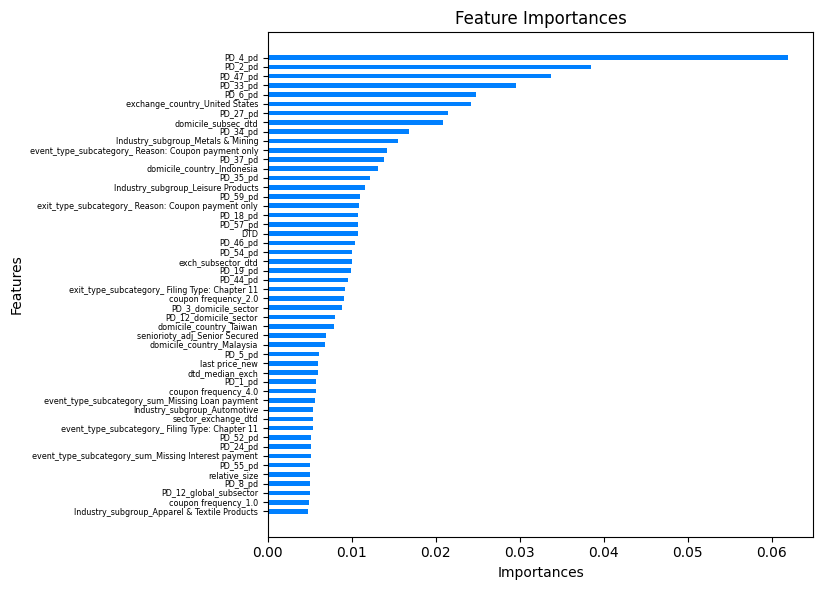

In [38]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'].tail(50), feature_importances['Importance'].tail(50), color=(0, 0.5, 1), height=0.5)  # Adjust the height for spacing

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')
plt.savefig(os.path.join(OUTPUT_PATH,'rf_feature_importance.png'))

plt.show()

5-fold CV

In [10]:
best_params

{'n_estimators': 973,
 'booster': 'gbtree',
 'colsample_bytree': 0.7648838093627683,
 'subsample': 0.876477043215285,
 'tree_method': 'auto',
 'max_depth': 6,
 'eta': 0.04018095879338747}

In [11]:
features = pd.concat([train_features, test_features], axis=0, ignore_index=True)
features

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,exit_type_subcategory_ Reason: Interest payment,exit_type_subcategory_ Reason: Loan payment,exit_type_subcategory_ Reason: Principal payment,exit_type_subcategory_ Reason: Unknown,exit_type_subcategory_0,exit_type_subcategory_Reason: Buyback option,exit_type_subcategory_Reason:From CBil (monthly update),exit_type_subcategory_Reason:From CBil (new/revised),defaulted_in_last_5_years_True,defaulted_in_last_6_months_True
0,7.500,-117.46020,-0.000189,125.407139,177.213028,134.012054,198.8153,191.364395,223.346344,0.1983,...,0,0,0,0,1,0,0,0,1,0
1,6.000,166.38276,0.000768,-4.603446,101.613617,77.032829,123.3998,105.932022,139.111115,0.0355,...,0,0,0,0,0,0,0,0,0,0
2,11.000,119.85752,0.000678,-11.950380,104.545959,77.416649,129.4317,111.818001,139.717407,0.0101,...,0,0,0,0,0,0,0,0,0,0
3,9.125,653.51208,0.001638,-2.494861,90.736633,64.654129,95.3731,92.141212,121.666237,0.0152,...,0,0,0,0,0,0,0,0,1,0
4,9.250,231.89472,0.000664,4.823413,98.533821,68.759308,93.4174,107.424469,139.741165,1.2865,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,3.250,147.33344,0.000556,3.538252,128.976395,95.360374,138.8445,138.946106,172.733887,0.0000,...,0,0,0,0,0,0,0,0,0,0
1721,10.000,175.31656,0.000554,-4.067337,121.170998,92.879501,123.2500,131.104904,162.916901,0.7516,...,1,0,0,0,0,0,0,0,1,0
1722,7.450,315.81748,0.000747,8.604100,126.786606,89.018188,114.9728,131.522430,171.701096,0.0864,...,0,0,0,0,0,0,0,0,0,0
1723,0.500,31.75120,-0.000157,-4.373852,126.595230,105.460007,121.6212,147.382416,163.772141,4.8375,...,0,0,0,0,0,0,0,0,0,0


In [12]:
labels = pd.concat([train_labels, test_labels], axis=0, ignore_index=True)
labels

,rr1_30
0,0.082481
1,0.378845
2,0.836149
3,0.987208
4,1.021458
...,...
1720,0.471411
1721,0.823750
1722,0.241612
1723,0.762054


In [13]:
model = xgb.XGBRegressor(n_jobs=-1, **best_params)
pipeline = Pipeline([
    ('preprocessor', scaler),
    ('svr', model)
])
# pipeline.fit(train_features, train_labels)

In [17]:
train_preds, oof_preds, feat_importances, train_metrics, val_metrics = run_kfold_eval(features, labels.to_numpy(), n_folds=5, model=pipeline, model_params=None, output_path=OUTPUT_PATH, name="xgboost")

100%|██████████| 5/5 [00:39<00:00,  7.93s/it]


In [19]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in train_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Training average mean absolute error: {mae/i}")
print(f"Training average mean absolute percentage error: {mape/i}")
print(f"Training average root mean squared error: {rmse/i}")
print(f"Training average R2: {rsqr/i}")

Training average mean absolute error: 0.37395889473874455
Training average mean absolute percentage error: 3600.9815283186226
Training average root mean squared error: 0.03840956166476096
Training average R2: 0.9864034756622043


In [18]:
# print test resuls
mae = 0
mape = 0
rmse = 0
rsqr = 0
i = 0

for key, value in val_metrics.items():
  if "mae" in key:
    i += 1
    mae += value

  if "mape" in key:
    mape += value

  if "rmse" in key:
    rmse += value

  if "rsqr" in key:
    rsqr += value

print(f"Test average mean absolute error: {mae/i}")
print(f"Test average mean absolute percentage error: {mape/i}")
print(f"Test average root mean squared error: {rmse/i}")
print(f"Test average R2: {rsqr/i}")

Test average mean absolute error: 0.3526239277048904
Test average mean absolute percentage error: 3687.375051263367
Test average root mean squared error: 0.2039751922301864
Test average R2: 0.6208502514222254
